In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os

2023-11-29 06:50:35.701323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Necessity

In [ ]:
test_results = glob.glob('../results/necessity_test/enformer/*pickle')

In [ ]:
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]
tile_coords = pd.read_csv('../old_results//sufficiency_test/enformer/tile_coordinates.csv', index_col='Unnamed: 0').T
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]

In [ ]:
result_summary = {}
for c, cell_line in enumerate(cell_lines):
    normalized_effects = []
    cell_line_context = pd.read_csv(f'../results/context_dependence_test/enformer/{cell_line}_context.csv')
    print(c, cell_line)
    for _, row in cell_line_context.iterrows():
        res_path = row['path'].replace('context_dependence_test', 'necessity_test')
        res_raw = utils.read_pickle(res_path) 
        res = {k: r[:, :, c].mean(axis=1) for k, r in res_raw.items()}
        # res['mut'] = np.delete(res['mut'], 19)
        one_seq = pd.DataFrame((res['wt'] - res['mut']) / res['wt'])
        one_seq.columns = ['Normalized shuffle effect']
        one_seq['seq_id'] = res_path.split('/')[-1].split('.')[0]
        one_seq['tile_start'] = cre_tile_coords[0].values
        one_seq['tile_end'] = cre_tile_coords[1].values
        one_seq['context'] = row['context']
        normalized_effects.append(one_seq)
    result_summary[cell_line] = pd.concat(normalized_effects)

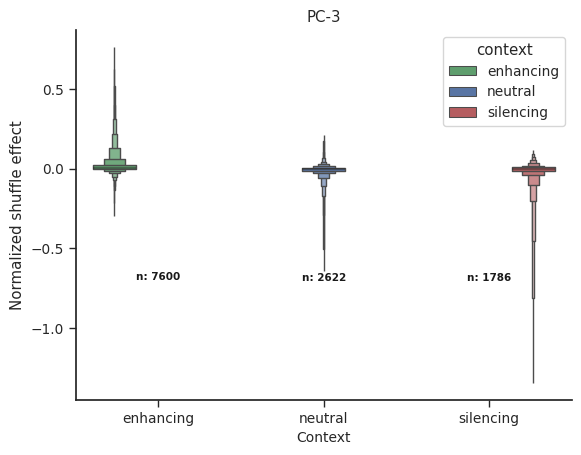

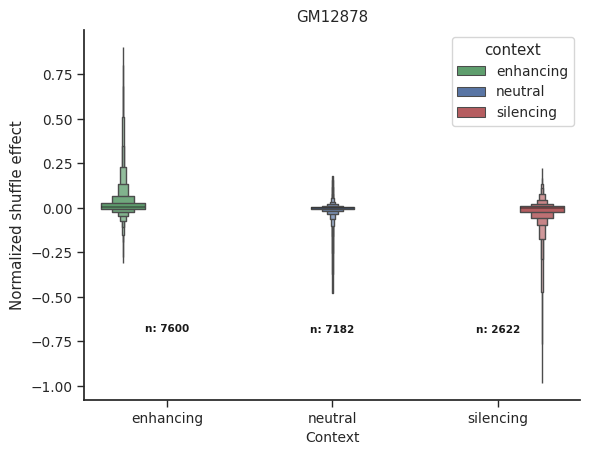

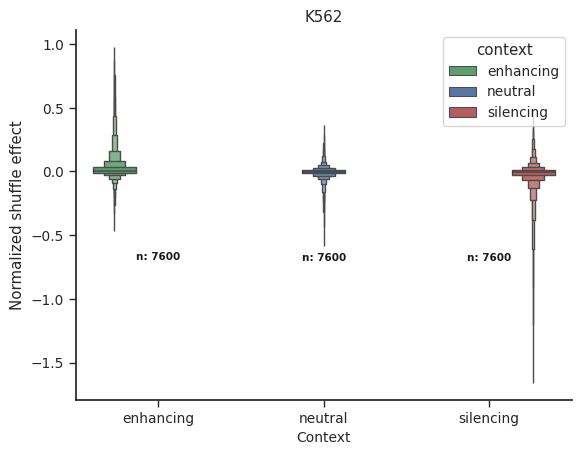

In [75]:
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

for cell, df in result_summary.items():
    ax=sns.boxenplot(x='context', y='Normalized shuffle effect', data=df, 
                  showfliers=False,
                  hue='context',
                  palette = my_pal)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Context', fontsize=10)

    # add number of observations in each box
    medians = df.groupby(['context'])['Normalized shuffle effect'].median().values
    nobs = df['context'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
                medians[tick] - .7,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='k',
                weight='semibold')
    plt.title(cell)
    plt.show()
    

In [77]:
df

,Normalized shuffle effect,seq_id,tile_start,tile_end,context,cell_line
0,-0.006986,DAPK1_chr9_87497866_+,804,5804,enhancing,K562
1,0.011106,DAPK1_chr9_87497866_+,5804,10804,enhancing,K562
2,0.001816,DAPK1_chr9_87497866_+,10804,15804,enhancing,K562
3,-0.000423,DAPK1_chr9_87497866_+,15804,20804,enhancing,K562
4,-0.002954,DAPK1_chr9_87497866_+,20804,25804,enhancing,K562
...,...,...,...,...,...,...
33,-0.002138,ACSL6_chr5_131994579_-,170804,175804,silencing,K562
34,-0.014060,ACSL6_chr5_131994579_-,175804,180804,silencing,K562
35,0.001644,ACSL6_chr5_131994579_-,180804,185804,silencing,K562
36,-0.109519,ACSL6_chr5_131994579_-,185804,190804,silencing,K562


In [79]:
selected_cres = []
for cell, df in result_summary.items():
    df['cell_line'] = cell
    enh_df = df[(df['Normalized shuffle effect'] > 0.3) & (df['context']=='enhancing')]
    enh_df['tile class'] = 'Enhancer'
    selected_cres.append(enh_df)
    sil_df = df[(df['Normalized shuffle effect'] < -0.3) & (df['context']=='silencing')]
    sil_df['tile class'] = 'Silencer'
    selected_cres.append(sil_df)
selected_cres = pd.concat(selected_cres)

/tmp/ipykernel_184734/399000856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enh_df['tile class'] = 'Enhancer'
/tmp/ipykernel_184734/399000856.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sil_df['tile class'] = 'Silencer'
/tmp/ipykernel_184734/399000856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [81]:
selected_cres.groupby(['cell_line', 'tile class', 'context']).count()

Normalized shuffle effect  seq_id  tile_start   
cell_line tile class context                                                    
GM12878   Enhancer   enhancing                        159     159         159  \
          Silencer   silencing                         40      40          40   
K562      Enhancer   enhancing                        226     226         226   
          Silencer   silencing                        158     158         158   
PC-3      Enhancer   enhancing                        136     136         136   
          Silencer   silencing                         41      41          41   

                                tile_end  
cell_line tile class context              
GM12878   Enhancer   enhancing       159  
          Silencer   silencing        40  
K562      Enhancer   enhancing       226  
          Silencer   silencing       158  
PC-3      Enhancer   enhancing       136  
          Silencer   silencing        41

In [82]:
selected_cres.to_csv('../results/necessity_test/enformer_selected_cres.csv')

# Sufficiency

In [35]:
test_results = glob.glob('../results/sufficiency_test/enformer/*pickle')

In [36]:
track_index = [4824, 5110, 5111]
bin_index = [447, 448]
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]

In [37]:
tile_coords = pd.read_csv('../results/sufficiency_test/enformer/tile_coordinates.csv', index_col='Unnamed: 0').T
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]

In [38]:
result_summary = {}
for c, cell_line in enumerate(cell_lines):
    normalized_effects = []
    cell_line_context = pd.read_csv(f'../results/context_dependence_test/enformer/{cell_line}_context.csv')
    print(c, cell_line)
    for _, row in cell_line_context.iterrows():
        res_path = row['path'].replace('context_dependence_test', 'sufficiency_test')
        res = utils.read_pickle(res_path) 
        res['wt'] = res['wt'][bin_index, c].mean(axis=0)
        res['mut'] = res['mut'][:, bin_index, c].mean(axis=1)
        res['control'] = res['control'][:, bin_index, c].mean(axis=1)
        # one_seq = pd.DataFrame((res['mut'] - res['control']) / res['wt'])
        one_seq = pd.DataFrame((res['mut']-res['control']) / res['wt'])

        one_seq.columns = ['(MUT - CONTROL) / WT']
        one_seq['(MUT - CONTROL) / CONTROL'] = (res['mut']-res['control']) / res['control']
        one_seq['seq_id'] = res_path.split('/')[-1].split('.')[0]
        one_seq['control'] = res['control']
        one_seq['wt'] = res['wt']
        one_seq['mut'] = res['mut']
        one_seq['tile_start'] = cre_tile_coords[0].values
        one_seq['tile_end'] = cre_tile_coords[1].values
        one_seq['context'] = row['context']
        normalized_effects.append(one_seq)
    result_summary[cell_line] = pd.concat(normalized_effects)

0 PC-3
1 GM12878
2 K562


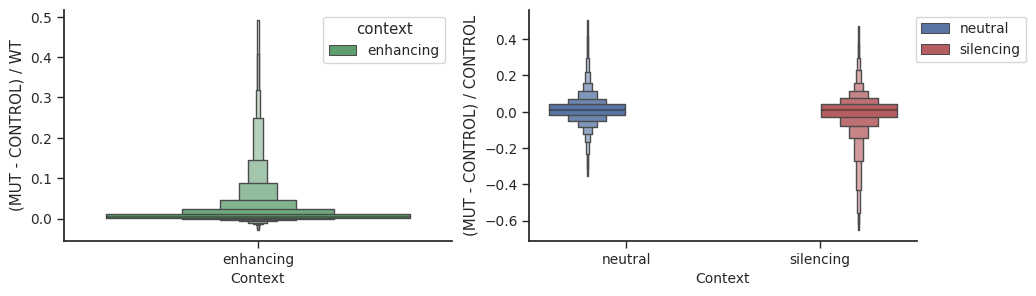

<Figure size 640x480 with 0 Axes>

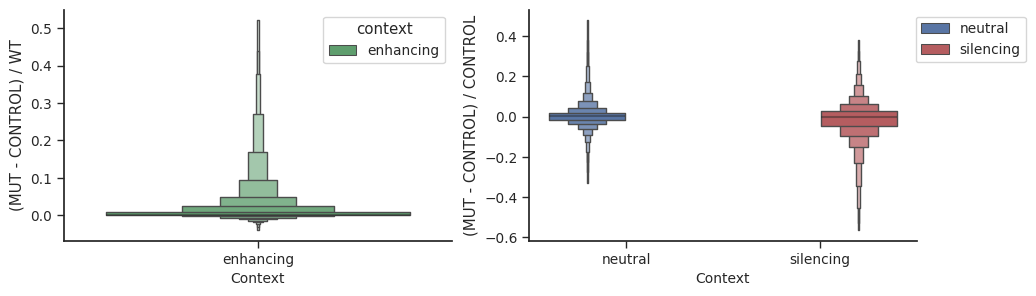

<Figure size 640x480 with 0 Axes>

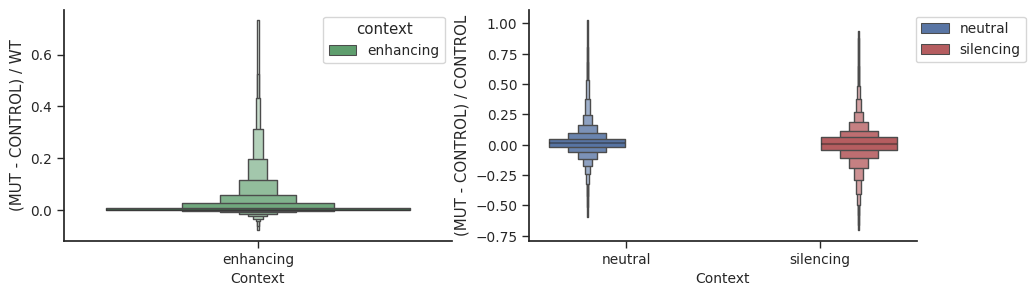

<Figure size 640x480 with 0 Axes>

In [39]:
my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True


for cell, df in result_summary.items():
    fig, axes = plt.subplots(1, 2, figsize=[11, 3])
    enh_cont = df[df['context'] == 'enhancing']
    others = df[df['context'] != 'enhancing']
    for p, (df_cont, y) in enumerate([[enh_cont, '(MUT - CONTROL) / WT'],
                                     [others, '(MUT - CONTROL) / CONTROL']]):
        ax = axes[p]
        sns.boxenplot(x='context', y=y, data=df_cont, 
                      showfliers=False,
                      hue='context',
                      ax=ax,
                      palette = my_pal)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Context', fontsize=10)
        
    plt.legend(bbox_to_anchor=[1.3,1])
    plt.show()
    plt.tight_layout()


        # add number of observations in each box
    # medians = df.groupby(['context'])[y].median().values
    # nobs = df['context'].value_counts().values
    # nobs = [str(x) for x in nobs.tolist()]
    # nobs = ["n: " + i for i in nobs]

    # # Add it to the plot
    # pos = range(len(nobs))
    # for tick,label in zip(pos,ax.get_xticklabels()):
    #     ax.text(pos[tick],
    #             medians[tick] - .7,
    #             nobs[tick],
    #             horizontalalignment='center',
    #             size='x-small',
    #             color='k',
    #             weight='semibold')
    # plt.title(cell)
    # # plt.ylim(0, 5)
    # plt.show()
    

In [10]:
print(result_summary['K562']['seq_id'].shape)
result_summary['K562']['seq_id'].unique().shape

(22800,)


(600,)

316.0

# threshold CREs for distance test

In [11]:
selected_cres = []
for cell, df in result_summary.items():
    df['cell_line'] = cell
    enh_cont_df = df[df['context']=='enhancing'] # only select enhancing CREs in enhancing contexts
    sil_cont_df = df[df['context']=='silencing'] # only select silencing CREs in silencing contexts
    enh_cont_df['Normalized CRE effect'] = enh_cont_df['(MUT - CONTROL) / WT'] # different norm for tiles from enh vs sil
    sil_cont_df['Normalized CRE effect'] = sil_cont_df['(MUT - CONTROL) / CONTROL']
    
    enh_cres = enh_cont_df[(enh_cont_df['Normalized CRE effect'] > 0.3)] 
    enh_cres['tile class'] = 'Enhancer'
    selected_cres.append(enh_cres)
    sil_cres = sil_cont_df[(sil_cont_df['Normalized CRE effect'] < -0.3)]
    sil_cres['tile class'] = 'Silencer'
    selected_cres.append(sil_cres)
selected_cres = pd.concat(selected_cres)

/tmp/ipykernel_3065462/188955257.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enh_cont_df['Normalized CRE effect'] = enh_cont_df['(MUT - CONTROL) / WT'] # different norm for tiles from enh vs sil
/tmp/ipykernel_3065462/188955257.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sil_cont_df['Normalized CRE effect'] = sil_cont_df['(MUT - CONTROL) / CONTROL']
/tmp/ipykernel_3065462/188955257.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [12]:
selected_cres.groupby(['cell_line', 'tile class', 'context']).count()

(MUT - CONTROL) / WT   
cell_line tile class context                           
GM12878   Enhancer   enhancing                    49  \
          Silencer   silencing                    61   
K562      Enhancer   enhancing                    63   
          Silencer   silencing                   224   
PC-3      Enhancer   enhancing                    38   
          Silencer   silencing                   101   

                                (MUT - CONTROL) / CONTROL  seq_id  control   
cell_line tile class context                                                 
GM12878   Enhancer   enhancing                         49      49       49  \
          Silencer   silencing                         61      61       61   
K562      Enhancer   enhancing                         63      63       63   
          Silencer   silencing                        224     224      224   
PC-3      Enhancer   enhancing                         38      38       38   
          Silencer   silencing                        101     101      101   

                                 wt  mut  tile_start  tile_end   
cell_line tile class context                                     
GM12878   Enhancer   enhancing   49   49          49        49  \
          Silencer   silencing   61   61          61        61   
K562      Enhancer   enhancing   63   63          63        63   
          Silencer   silencing  224  224         224       224   
PC-3      Enhancer   enhancing   38   38          38        38   
          Silencer   silencing  101  101         101       101   

                                Normalized CRE effect  
cell_line tile class context                           
GM12878   Enhancer   enhancing                     49  
          Silencer   silencing                     61  
K562      Enhancer   enhancing                     63  
          Silencer   silencing                    224  
PC-3      Enhancer   enhancing                     38  
          Silencer   silencing                    101

In [9]:
selected_cres.to_csv('../results/sufficiency_test/enformer_selected_cres.csv')

In [14]:
selected_cres_old = pd.read_csv('../results/sufficiency_test/enformer_selected_cres.csv')

In [15]:
selected_cres_old[(selected_cres_old['context']=='silencing') & (selected_cres_old['tile class']=='Silencer')
                    & (selected_cres_old['cell_line']=='K562')]

,Unnamed: 0,Normalized CRE effect,seq_id,tile_start,tile_end,context,cell_line,tile class
1286,23,-0.452357,E2F6_chr2_11466161_-,120804,125804,silencing,K562,Silencer
1287,19,-0.421207,ZNF264_chr19_57191500_+,100804,105804,silencing,K562,Silencer
1288,22,-1.296589,ZNF264_chr19_57191500_+,115804,120804,silencing,K562,Silencer
1289,19,-0.464720,GZF1_chr20_23362181_+,100804,105804,silencing,K562,Silencer
1290,20,-0.617411,ZNF586_chr19_57769654_+,105804,110804,silencing,K562,Silencer
...,...,...,...,...,...,...,...,...
1795,21,-0.774285,TRAPPC2B_chr19_57363566_+,110804,115804,silencing,K562,Silencer
1796,8,-0.324218,ACSL6_chr5_131994579_-,40804,45804,silencing,K562,Silencer
1797,14,-0.786562,ACSL6_chr5_131994579_-,70804,75804,silencing,K562,Silencer
1798,19,-0.580070,ACSL6_chr5_131994579_-,100804,105804,silencing,K562,Silencer


In [13]:
sil = selected_cres[(selected_cres['context']=='silencing') & (selected_cres['tile class']=='Silencer')
                    & (selected_cres['cell_line']=='K562')]

In [16]:
sil.head()

,(MUT - CONTROL) / WT,(MUT - CONTROL) / CONTROL,seq_id,control,wt,mut,tile_start,tile_end,context,cell_line,Normalized CRE effect,tile class
22,-0.408031,-0.327417,TIGAR_chr12_4321212_+,83.272110,66.820122,56.007416,115804,120804,silencing,K562,-0.327417,Silencer
20,-0.493833,-0.353583,ZNF799_chr19_12401268_-,29.302832,20.980736,18.941854,105804,110804,silencing,K562,-0.353583,Silencer
28,-0.421487,-0.304610,ZNF799_chr19_12401268_-,29.030912,20.980736,20.187807,145804,150804,silencing,K562,-0.304610,Silencer
22,-0.618339,-0.531882,RTL8C_chrX_135032354_+,66.685257,57.361183,31.216572,115804,120804,silencing,K562,-0.531882,Silencer
18,-0.960206,-0.442578,FAM13B_chr5_138033031_-,36.109310,16.643503,20.128120,90804,95804,silencing,K562,-0.442578,Silencer


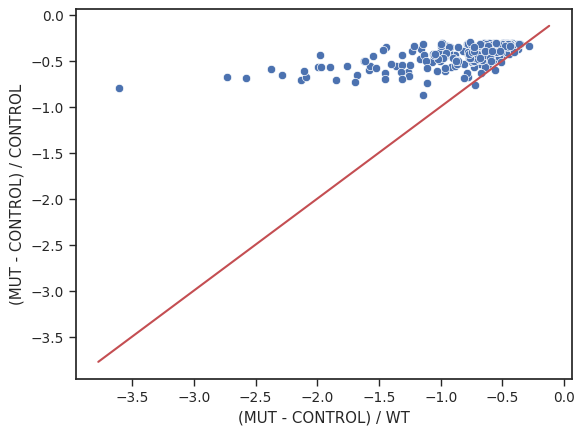

In [17]:
ax=sns.scatterplot(data=sil, x='(MUT - CONTROL) / WT', y='(MUT - CONTROL) / CONTROL')
X_plot = np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]))
plt.plot(X_plot, X_plot, color='r')

In [18]:
sil[sil['(MUT - CONTROL) / WT'] < -2.5]

,(MUT - CONTROL) / WT,(MUT - CONTROL) / CONTROL,seq_id,control,wt,mut,tile_start,tile_end,context,cell_line,Normalized CRE effect,tile class
21,-2.575021,-0.688734,ZNF599_chr19_34773229_-,78.872345,21.095781,24.550268,110804,115804,silencing,K562,-0.688734,Silencer
19,-3.608432,-0.795837,ZNF501_chr3_44729595_+,81.160980,17.900002,16.570038,100804,105804,silencing,K562,-0.795837,Silencer
22,-2.733802,-0.677392,G0S2_chr1_209675411_+,55.089947,13.650400,17.772453,115804,120804,silencing,K562,-0.677392,Silencer


In [67]:
sil[np.abs(sil['(MUT - CONTROL) / WT']- sil['(MUT - CONTROL) / CONTROL'])<0.01]

,(MUT - CONTROL) / WT,(MUT - CONTROL) / CONTROL,seq_id,control,wt,mut,tile_start,tile_end,context,cell_line,Normalized CRE effect,tile class
27,-0.370575,-0.373289,PROSER2_chr10_11823355_+,54.971535,55.374027,34.451286,140804,145804,silencing,K562,-0.373289,Silencer
19,-0.405776,-0.403275,CPLX1_chr4_826092_-,17.090450,16.985102,10.198305,100804,105804,silencing,K562,-0.403275,Silencer
16,-0.512794,-0.509079,ZIM2_chr19_56840726_-,28.674667,28.466919,14.076987,80804,85804,silencing,K562,-0.509079,Silencer


In [73]:
sil[np.abs(sil['wt']-55)<1]

,(MUT - CONTROL) / WT,(MUT - CONTROL) / CONTROL,seq_id,control,wt,mut,tile_start,tile_end,context,cell_line,Normalized CRE effect,tile class
21,-0.520545,-0.376097,ZNF275_chrX_153334146_+,75.127609,54.280231,46.872330,110804,115804,silencing,K562,-0.376097,Silencer
19,-0.955543,-0.408762,ZNF222_chr19_44025378_+,127.061516,54.354351,75.123604,100804,105804,silencing,K562,-0.408762,Silencer
26,-0.651963,-0.303020,ZNF222_chr19_44025378_+,116.946182,54.354351,81.509178,135804,140804,silencing,K562,-0.303020,Silencer
21,-2.095367,-0.678423,ZNF260_chr19_36528271_-,168.743042,54.634407,54.263885,110804,115804,silencing,K562,-0.678423,Silencer
15,-0.287310,-0.338675,PROSER2_chr10_11823355_+,46.975708,55.374027,31.066202,75804,80804,silencing,K562,-0.338675,Silencer
27,-0.370575,-0.373289,PROSER2_chr10_11823355_+,54.971535,55.374027,34.451286,140804,145804,silencing,K562,-0.373289,Silencer
29,-0.721233,-0.761994,PROSER2_chr10_11823355_+,52.411892,55.374027,12.474334,150804,155804,silencing,K562,-0.761994,Silencer
21,-0.866621,-0.495112,NFIL3_chr9_91423832_-,94.722992,54.116493,47.824512,110804,115804,silencing,K562,-0.495112,Silencer
14,-0.437827,-0.316338,ZNF506_chr19_19821740_-,76.015305,54.922417,51.968803,70804,75804,silencing,K562,-0.316338,Silencer
16,-0.470947,-0.404101,ZNF506_chr19_19821740_-,64.007637,54.922417,38.142090,80804,85804,silencing,K562,-0.404101,Silencer


In [131]:
(16.612587 - 16.374414) / 16.612587	

0.014336900086663187

In [20]:
context_effect = pd.read_csv('../results/context_dependence_test/enformer/K562_context.csv')

In [43]:
context_effect[context_effect['path']=='../results/context_dependence_test/enformer/PROSER2_chr10_11823355_+.pickle']

,Unnamed: 0,delta mean,path,wt,context,cell line
453,2455,-0.310653,../results/context_dependence_test/enformer/PR...,55.36822,silencing,K562


In [40]:
res_con = utils.read_pickle('../results/context_dependence_test/enformer/PROSER2_chr10_11823355_+.pickle')

In [41]:
res_con['wt'][[447, 448],2].mean()

55.36822

In [42]:
res_con['mut'][[447, 448],2].mean()

72.56853

In [45]:
seq_parser=utils.SequenceParser('../data/GRCh38.primary_assembly.genome.fa')

In [46]:
model = custom_model.Enformer()

2023-12-01 17:16:36.765897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 17:16:37.758271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 69493 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:85:00.0, compute capability: 8.0


In [82]:
seq = seq_parser.extract_seq_centered('chr10', 11823355, '+', model.seq_length)

In [83]:
import shuffle

In [84]:
wt = model.predict(seq)

In [85]:
wt[0,447:449,5111].mean()

55.367

In [87]:
no_contex_preds = []
cre_preds = []
for _ in tqdm(range(100)):
    x_mut = shuffle.dinuc_shuffle(seq)
    x_mut[(model.seq_length-5000)//2:(model.seq_length+5000)//2] = seq[(model.seq_length-5000)//2:(model.seq_length+5000)//2].copy()
    no_contex_preds.append((model.predict(x_mut)[0,447:449,5111].mean()))
    x_mut[110804:115804] = seq[110804:115804]
    cre_preds.append(model.predict(x_mut)[0,447:449,5111].mean())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


In [91]:
cre_preds = np.array(cre_preds)
no_contex_preds = np.array(no_contex_preds)

In [92]:
normalized_vals = (cre_preds-no_contex_preds) / no_contex_preds

In [97]:
for _ in range(10):
    print(np.random.choice(normalized_vals, 20).mean())
    

-0.261838
-0.37341997
-0.3347621
-0.26161236
-0.3485108
-0.36653435
-0.2477837
-0.33084053
-0.3775805
-0.3690301


<Axes: >

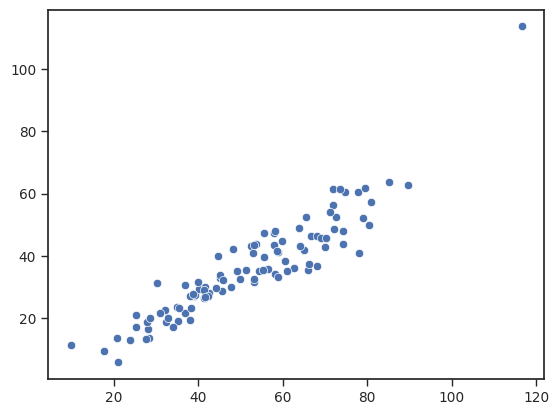

In [89]:
sns.scatterplot(x=no_contex_preds, y=cre_preds)

<Axes: ylabel='Count'>

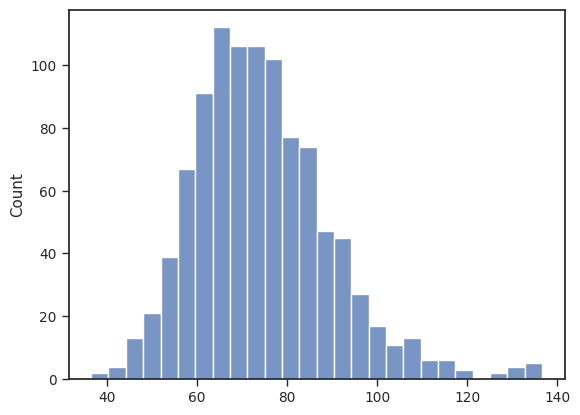

In [78]:
sns.histplot(no_contex_preds)

<Axes: ylabel='Count'>

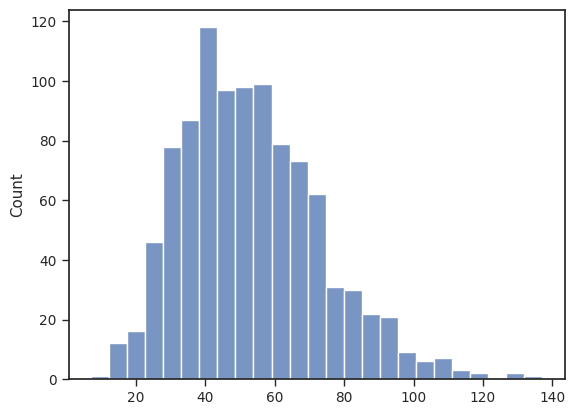

In [66]:
sns.histplot(no_contex_preds)

In [79]:
np.max(no_contex_preds)

136.61484

In [80]:
np.std((no_contex_preds))

15.360408

In [81]:
np.mean((no_contex_preds))

74.487595

In [25]:
i = 2
creme.context_effect_on_tss(res_con['wt'][[447, 448],i].mean(), res_con['mut'][[447, 448],i].mean())


-0.31065303

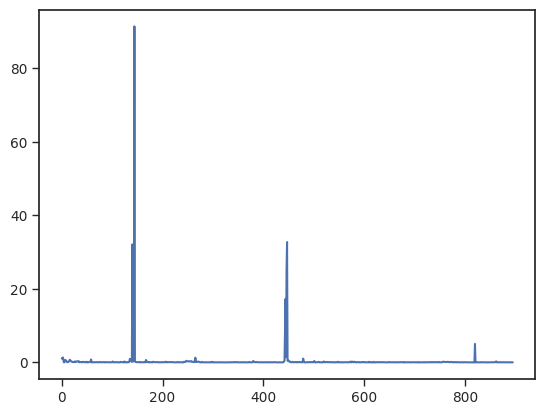

In [155]:
plt.plot(res_con['wt'][:,i])

In [156]:
res_con['wt'][447:449,i]

array([32.73653   ,  0.46131152], dtype=float32)

In [157]:
res_con['mut'][447:449,i]

array([32.608902 ,  0.7939304], dtype=float32)

<Axes: xlabel='Normalized CRE effect', ylabel='Count'>

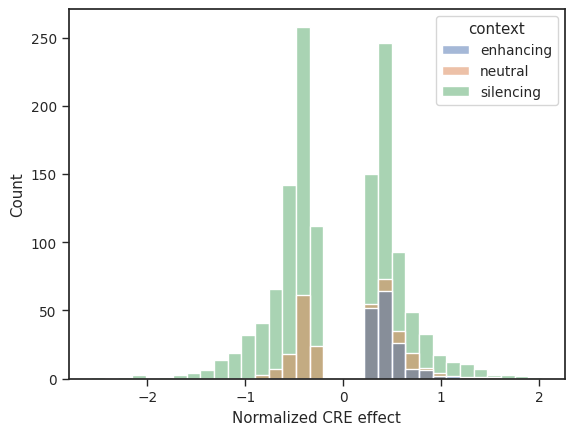

In [10]:
sns.histplot(data=selected_cres, x='Normalized CRE effect', hue='context')

In [214]:
selected_cres

,Normalized CRE effect,seq_id,tile_start,tile_end,context,cell_line
18,0.643710,SIGMAR1_chr9_34635317_-,90804,95804,enhancing,PC-3
18,0.488182,S100A11_chr1_152032505_-,90804,95804,enhancing,PC-3
20,0.393512,ARHGAP11A_chr15_32615503_+,105804,110804,enhancing,PC-3
19,0.391855,PSMD1_chr2_231056893_+,100804,105804,enhancing,PC-3
19,0.309734,APOBEC3C_chr22_39014256_+,100804,105804,enhancing,PC-3
...,...,...,...,...,...,...
21,-1.153904,ZNF570_chr19_37469355_+,110804,115804,silencing,K562
22,-0.341064,ZNF570_chr19_37469355_+,115804,120804,silencing,K562
19,-0.310034,ENSG00000288000_chr20_43458053_+,100804,105804,silencing,K562
23,-0.861627,ENSG00000267179_chr19_11925110_+,120804,125804,silencing,K562


In [147]:
12996 / 38

342.0